# Tutorial: Understanding PLUMED

Getting tutorial files using command line 
```
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/plumed_intro.ipynb
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/xvg_plot.py
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/funcs.py

```

In this tutorial we will learn how to launch Gromacs with PLUMED and define collective variables (CVs).
We will use a short peptide as a test system.

Full PLUMED documentation is here https://plumed.github.io/doc-v2.3/user-doc/html/_syntax.html
For full Gromacs manual, see here http://manual.gromacs.org



## Step 1: Getting, a peptide structure
We will get a short alpha-helix from  H4-histone.

In [1]:
%%bash --out output --err error
wget https://files.rcsb.org/view/1KX5.pdb

In [4]:
import MDAnalysis as mda
nucl=mda.Universe("1KX5.pdb")

sel_text="(segid B and (resid 24:29 or (resid 23 and name C O CA) or (resid 30 and name N CA)))"
h4helix=nucl.select_atoms(sel_text)


nucl.select_atoms("segid B and resid 23").residues.resnames='ACE'
nucl.select_atoms("segid B and resid 23 and name CA").atoms.names='CH3'
nucl.select_atoms("segid B and resid 30").residues.resnames='NME'
nucl.select_atoms("segid B and resid 30 and name CA").atoms.names='CH3'


nucl.trajectory.remarks=[]
nucl.trajectory.compound=[]
nucl.trajectory.header=['H4 helix']

#print(dimer.atoms.names)
h4helix.write("sys.pdb")

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [20]:
import nglview as nv
a=nv.show_mdanalysis(h4helix,gui=False)
a.add_representation(selection='protein',repr_type='spacefill')
a.render_image()
a

NGLWidget()

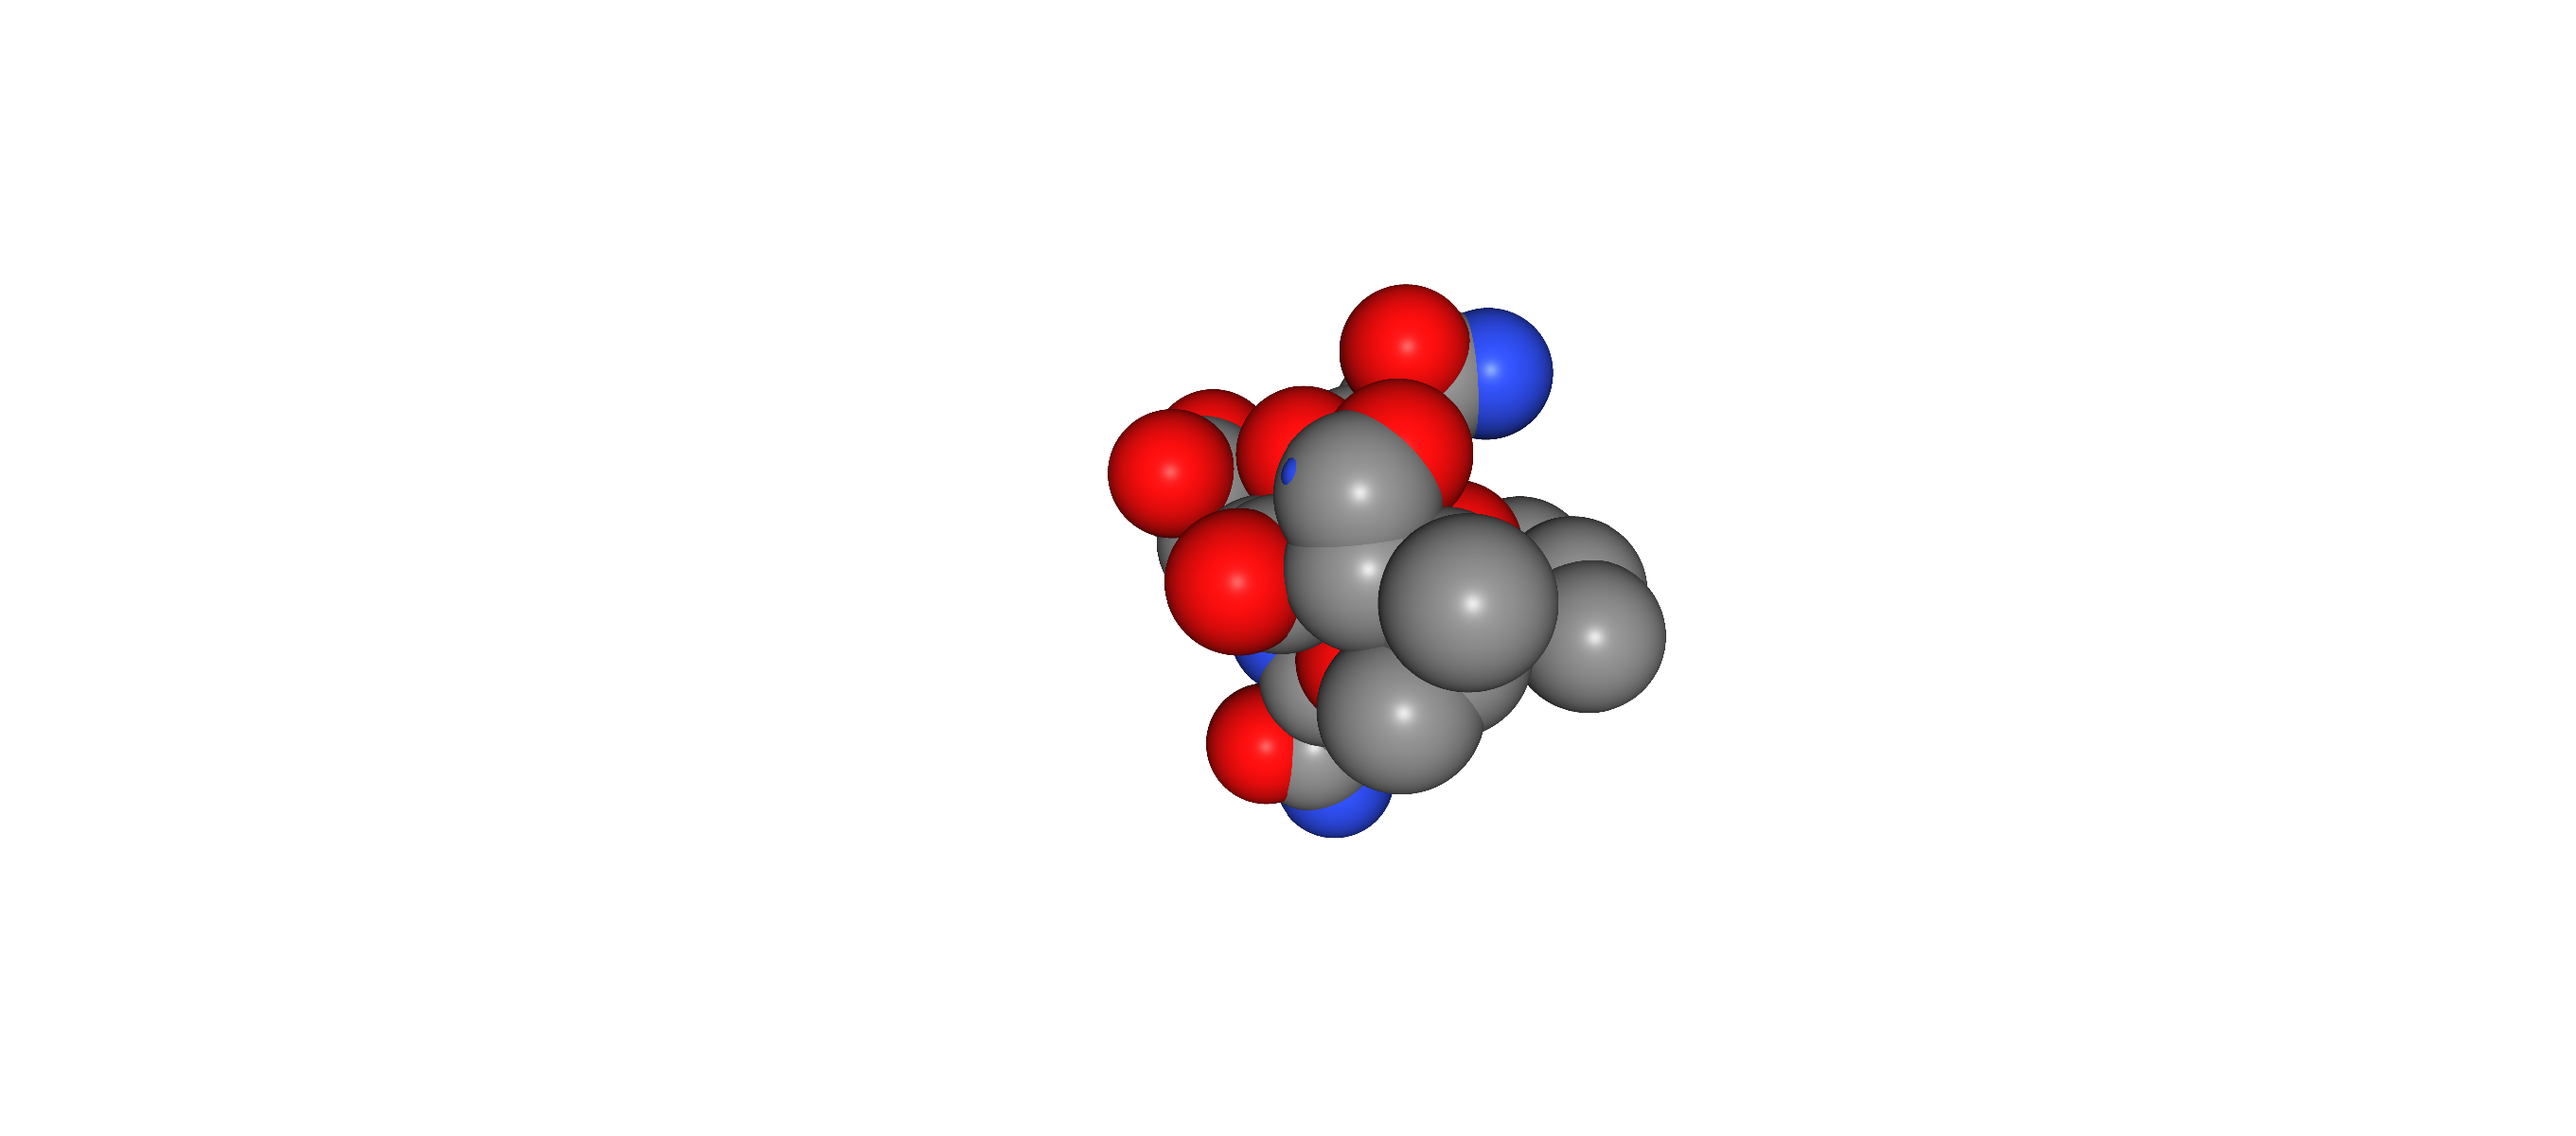

In [21]:
a._display_image()

## Step 2. Prepair system for simulations in Gromacs.
It is expected that you have completed the Gromacs tutorial and understand following steps without explanation.


In [5]:
#First get mdp files.
!rm -rf MDProtocols
from funcs import get_files_from_git
prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber_quick"
get_files_from_git(prot_url,'MDProtocols/')

In [6]:
!gmx pdb2gmx -f sys.pdb -o init.pdb -p topol.top -water tip3p -ff amber99sb-ildn

                     :-) GROMACS - gmx pdb2gmx, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [7]:
#First put a system in a periodic box, with 1 nm distance to the walls (-d), centered in the box (-c)
!gmx editconf -d 1 -c -f init.pdb -o init_box.pdb

                     :-) GROMACS - gmx editconf, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

In [8]:
#Now to the solvation, note, the topology file will be updated to reflect the added water molecules.
!gmx solvate -cp init_box.pdb -cs spc216.gro -o init_solv.pdb -p topol.top

                     :-) GROMACS - gmx solvate, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [9]:
#Let's look at the protein in a water box.
import nglview as nv
a=nv.show_structure_file('init_solv.pdb')
a.add_representation('licorice')
a

NGLWidget()

In [13]:
!gmx grompp -f MDProtocols/ions.mdp -c init_solv.pdb -p topol.top -o ions.tpr -maxwarn 1

                      :-) GROMACS - gmx grompp, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

And now run genions http://manual.gromacs.org/documentation/current/onlinehelp/gmx-genion.html

In [14]:
%%bash
gmx genion -s ions.tpr -o init_solv_ions.pdb -p topol.top -conc 0.150 -neutral <<!
SOL
!

Will try to add 4 NA ions and 3 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 7 solute molecules in topology file (topol.top)  by 4 NA and 3 CL ions.


                      :-) GROMACS - gmx genion, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [15]:
#Let's look at the protein in a water box with ions.
import nglview as nv
a=nv.show_structure_file('init_solv_ions.pdb')
a.add_representation('licorice')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a

NGLWidget()

The `grompp` comand packs topology together with mdp file into a .tpr file - the sole file needed to start minimization/simulation.
See details here http://manual.gromacs.org/documentation/current/onlinehelp/gmx-grompp.html

In [16]:
!gmx grompp -f MDProtocols/minim.mdp -c init_solv_ions.pdb -p topol.top -o minim.tpr -r init_solv_ions.pdb

                      :-) GROMACS - gmx grompp, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Now let's run the minimization, this may take a while ...

In [17]:
!gmx mdrun -nt 10 -deffnm minim # nt is the number of threads, choose less than the number of CPUs you have

                      :-) GROMACS - gmx mdrun, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [20]:
!gmx grompp -f MDProtocols/equil.mdp -c minim.gro -p topol.top -o equil.tpr -r init_solv_ions.pdb

                      :-) GROMACS - gmx grompp, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

In [21]:
!gmx mdrun -nt 10 -deffnm equil # nt is the number of threads, choose less than the number of CPUs you have

                      :-) GROMACS - gmx mdrun, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [22]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','equil.xtc')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice',selection='protein')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

NGLWidget(count=101)

Finally, let's prepare the 1 ns production file.

In [1]:
!gmx grompp -f MDProtocols/prod.mdp -c equil.gro -p topol.top -o prod.tpr -r init_solv_ions.pdb

                      :-) GROMACS - gmx grompp, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

## Step 3. Now we are ready to explore PLUMED
- Invoking GROMACS to use PLUMED is as ```gmx mdrun -plumed plumed.dat```
- We'll need to make a plumed.dat file with commands for PLUMED

## Let's start with simply reporting distance between the end of our helix
The code should look as
```
d1: DISTANCE ATOMS=1,2
PRINT ARG=d1 FILE=colvar STRIDE=10
```
But we need to specify atom numbers, this can be done by MDanalysis code. Let's do it.

In [2]:
import MDAnalysis as mda
import MDAnalysis.analysis.hbonds
import MDAnalysis.analysis.distances

#Let's load a structure with hydrogens, assumed the numbering is the same with full system, since water and ions are added to the end.
nucl=mda.Universe("init_box.pdb")

sel_end1="(segid B and resid 24 and name CA)"
sel_end2="(segid B and resid 29 and name CA)"


E1=nucl.select_atoms(sel_end1)

E2=nucl.select_atoms(sel_end2)

d=MDAnalysis.analysis.distances.dist(E1,E2)[2][0]/10.
print("Initinal distance=",d,"nm")

e1=E1.atoms[0].id
e2=E2.atoms[0].id
print("Atom1id=",e1,"Atom2id=",e2,"\n ----")

#Now let's write a plumed.dat file
!echo "d1: DISTANCE ATOMS=$e1,$e2" >plumed.dat
!echo "PRINT ARG=d1 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat

Initinal distance= 0.8285016256496333 nm
Atom1id= 9 Atom2id= 78 
 ----
d1: DISTANCE ATOMS=9,78
PRINT ARG=d1 FILE=colvar.dat STRIDE=10


In [3]:
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat # nt is the number of threads, choose less than the number of CPUs you have

                      :-) GROMACS - gmx mdrun, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

In [4]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice',selection='protein')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=11)

Labels found: ['time', 'd1']


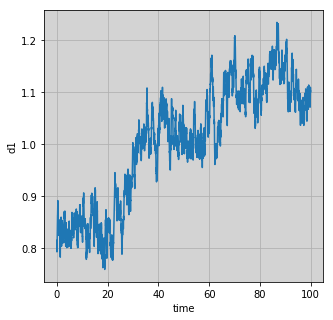

In [25]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
plot_plumed('colvar.dat',figsize=(5,5))

Last Frame read : 501, time : 1000.0 ps
501 frame read in 0.17 seconds


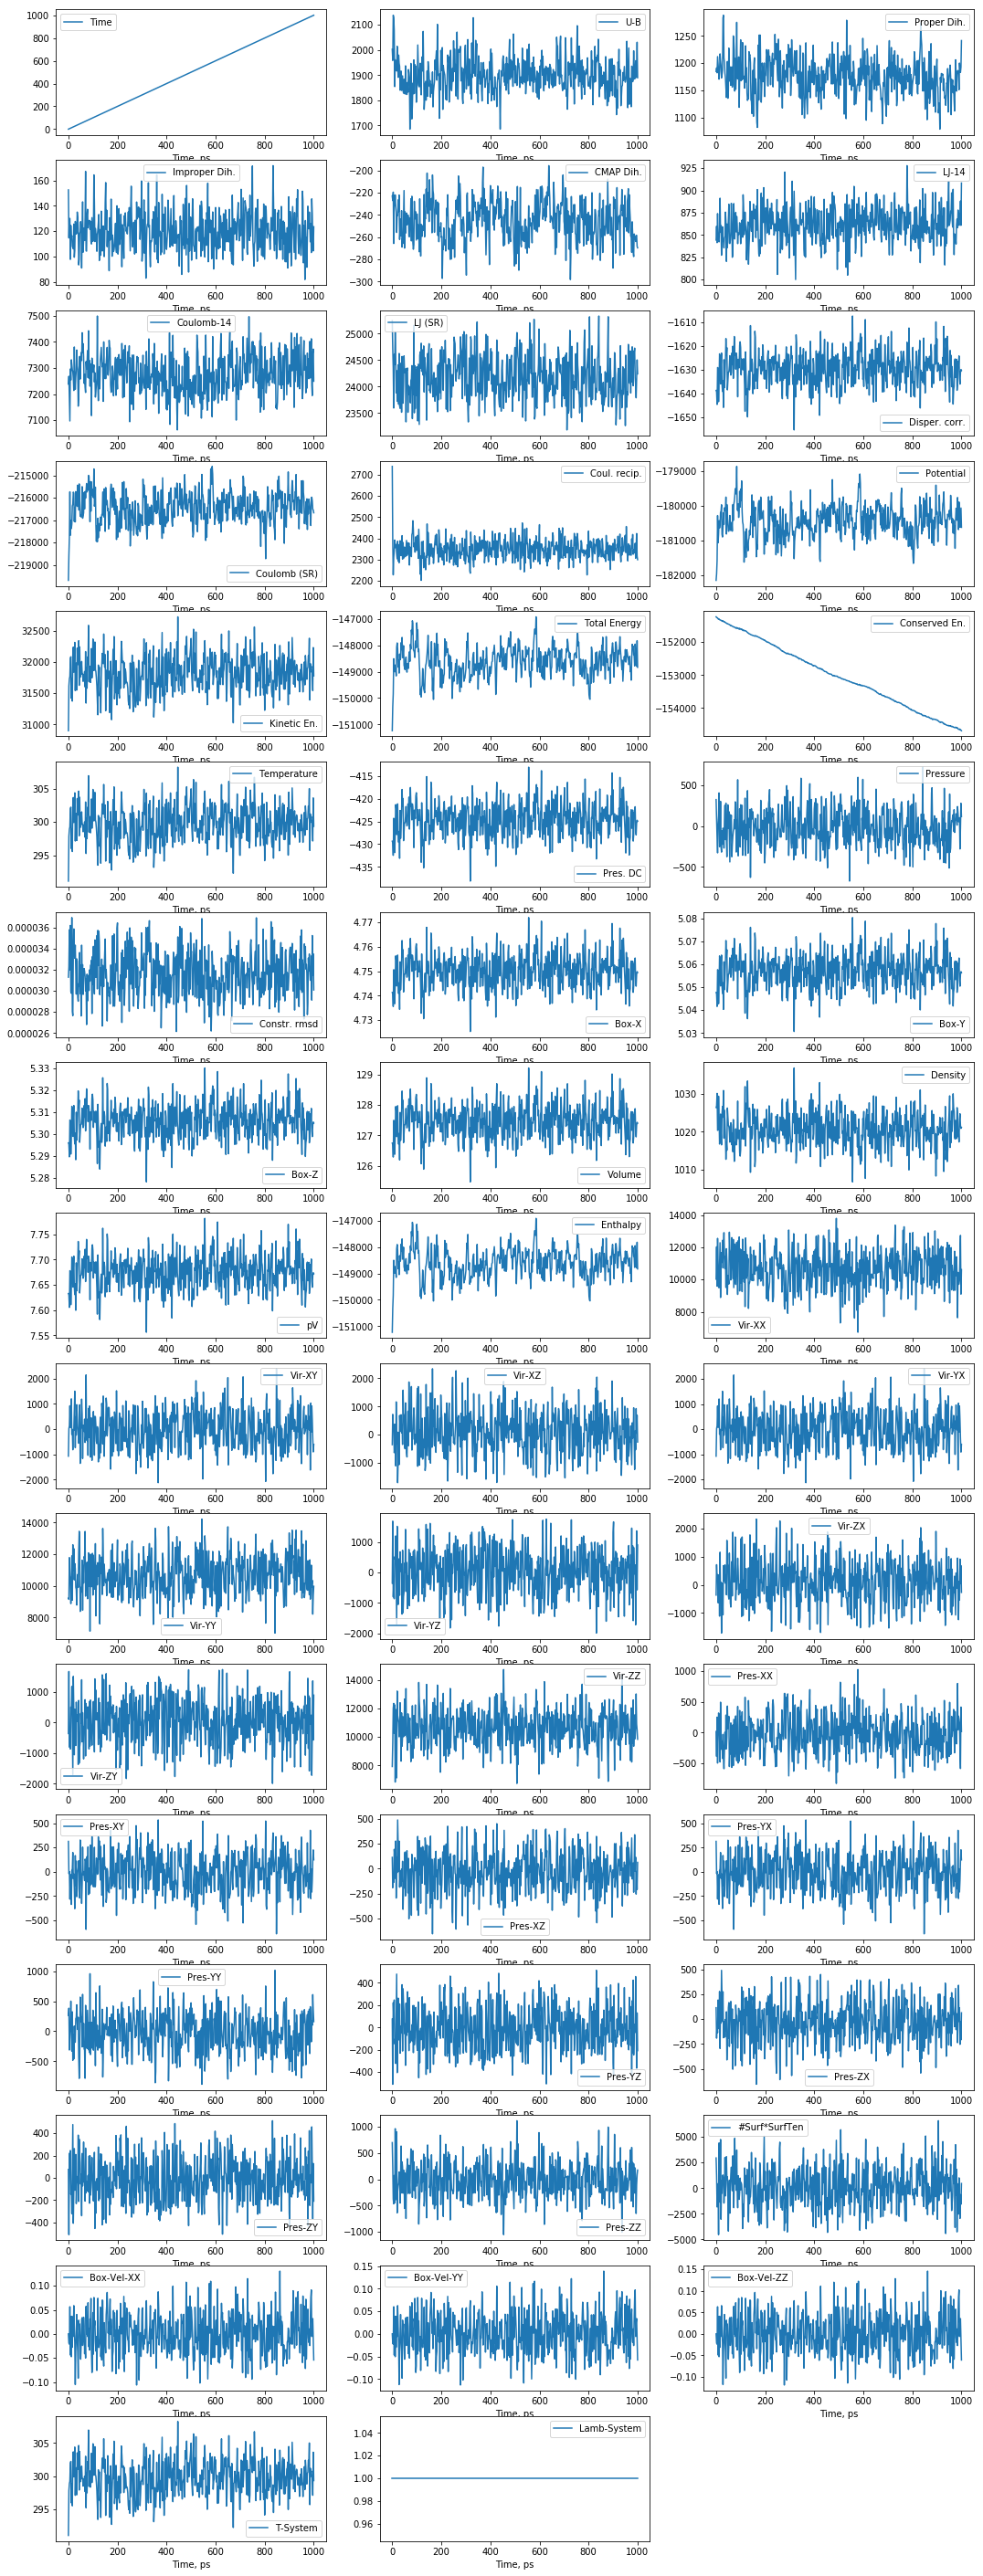

In [32]:
import panedr
import matplotlib.pyplot as plt
%matplotlib inline
df = panedr.edr_to_df('prod.edr', verbose=True)
num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key][0::1],label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

## Step 6. Trajectory analysis.


- RMSD, Rgyration
- Fluctuations along the sequence
- Interactions with water and ions
- Binding pocket accessibility
- Cluster analysis
- PCA